# Operations Research

In [99]:
# Helper
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *
import numpy as np
import random

def print_graph(G):
    # Create a layout for the graph
    pos = nx.spring_layout(G)
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12)
    # Display the graph
    plt.axis('off')
    plt.show()

# MTZ TSP formulation
def solveTSPexact(graph):
    model = Model("tsp")

    M = graph.number_of_edges() * 1000

    # non verbose
    model.setParam('OutputFlag', 0)

    # Add variables
    x = {}
    for i in graph.nodes():
        for j in graph.nodes():
            if i != j:
                x[i, j] = model.addVar(vtype=GRB.BINARY)

    u = {}
    for i in graph.nodes():
        u[i] = model.addVar(vtype=GRB.CONTINUOUS)

    # Add constraints
    for i in graph.nodes():
        model.addConstr(quicksum(x[i, j] for j in graph.nodes() if i != j) == 1, name="out%d" % i)
        model.addConstr(quicksum(x[j, i] for j in graph.nodes() if i != j) == 1, name="in%d" % i)

    model.addConstr(u[0] == 1, name="u0")

    for i in graph.nodes():
        for j in graph.nodes():
            if j!=0 and i!=j:
                model.addConstr(u[i] - u[j] + M * x[i, j] <= M-1, name="order%d,%d" % (i, j))
    
    # Set objective
    model.setObjective(quicksum(graph[i][j]['weight'] * x[i, j] for i in graph.nodes() for j in graph.nodes() if i != j), GRB.MINIMIZE)

    # Optimize
    model.update()
    model.optimize()

    tour = [0]
    for i in range(graph.number_of_nodes()-1):
        for j in graph.nodes():
            if j != tour[-1] and x[tour[-1], j].x > 0.5:
                tour.append(j)
                break
    tour.append(0)

    return tour

## Komplexitätstheorie

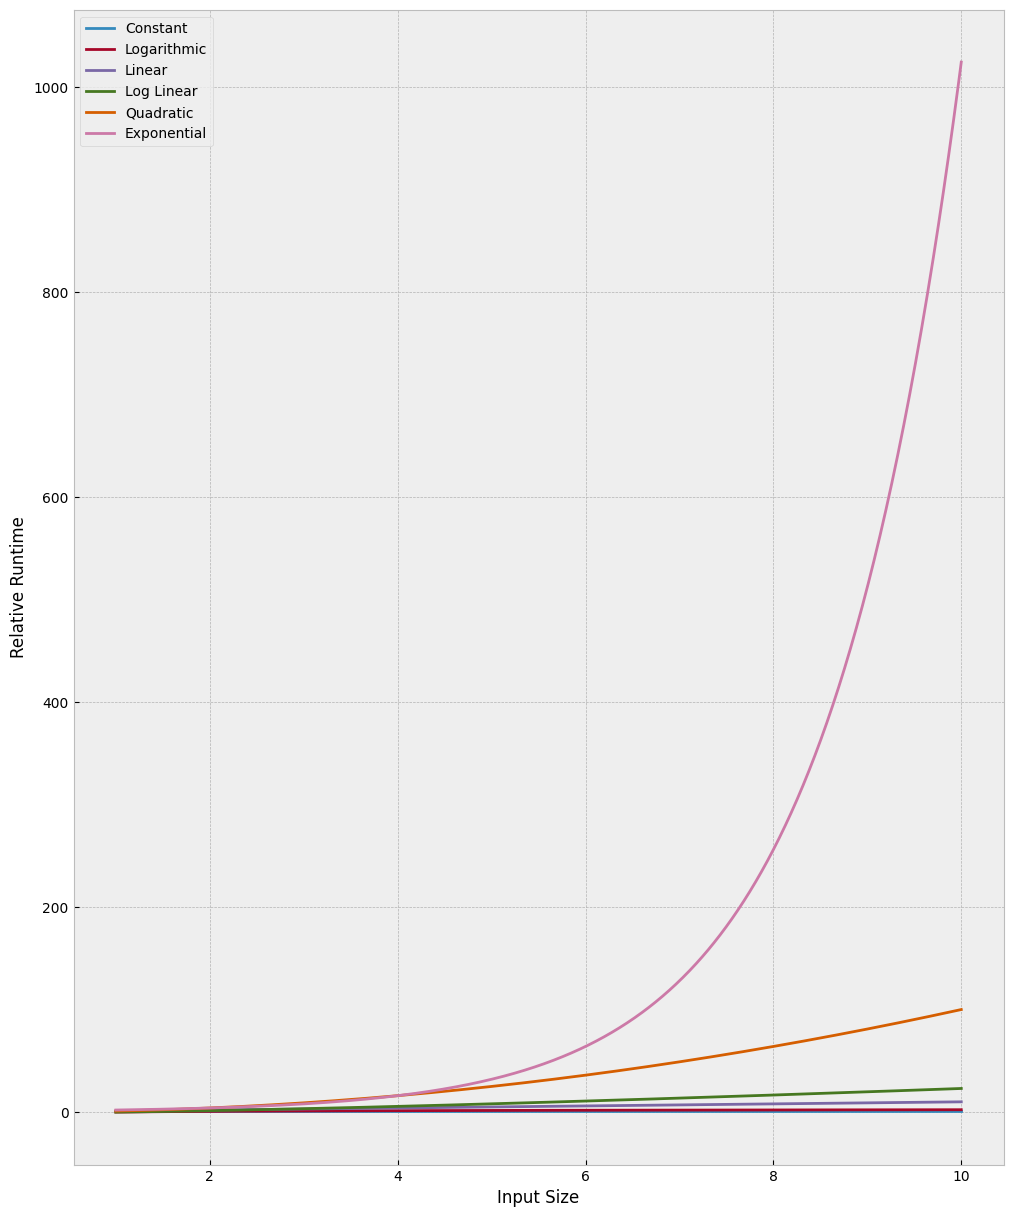

In [100]:
# Stylesheets defined in Matplotlib
plt.style.use('bmh')

# Set up runtime comparisons
n = np.linspace(1, 10, 1000)
labels = ['Constant', 'Logarithmic', 'Linear', 'Log Linear', 'Quadratic', 'Exponential']
big_o = [np.ones(n.shape), np.log(n), n, n * np.log(n), n**2, 2**n]

# Plot setup
plt.figure(figsize=(12, 15))

for i in range(len(big_o)):
    plt.plot(n, big_o[i], label=labels[i])

plt.legend(loc=0)
plt.ylabel('Relative Runtime')
plt.xlabel('Input Size')
plt.savefig('big-o-notation.png')

## TSP Probleminstanz

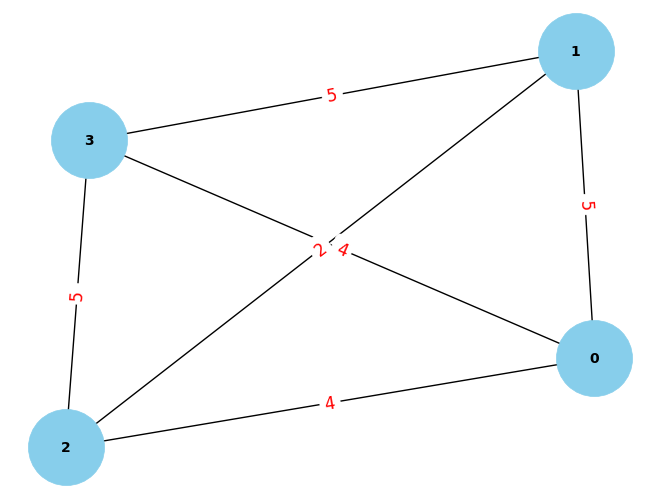

[0, 3, 1, 2, 0]

In [101]:
import networkx as nx

# Create a graph with 4 nodes with an obvious tsp solution
G = nx.Graph()
G.add_edge(0, 1, weight=5)
G.add_edge(0, 2, weight=4)
G.add_edge(0, 3, weight=4)
G.add_edge(1, 2, weight=2)
G.add_edge(1, 3, weight=5)
G.add_edge(2, 3, weight=5)

print_graph(G)
solveTSPexact(G)


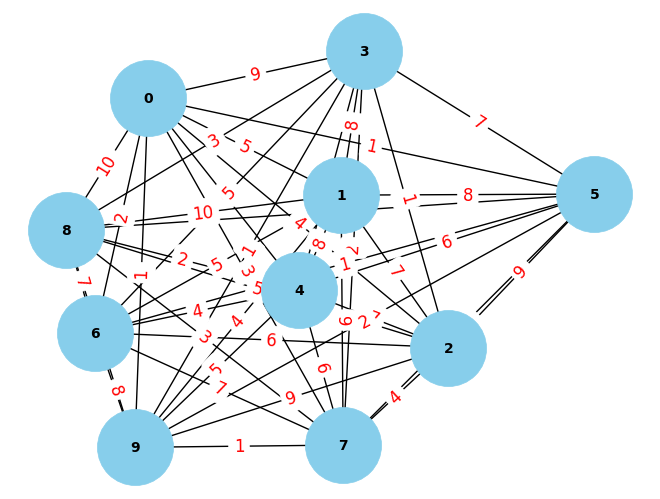

[0, 6, 5, 8, 4, 3, 2, 7, 9, 1, 0]

In [102]:
# Create a graph with more nodes with an obvious tsp solution
G = nx.Graph()

G = nx.complete_graph(10)

# Assign random edge weights (integer values) to the edges
for u, v in G.edges():
    weight = random.randint(1, 10)  # You can adjust the weight range as needed
    G[u][v]['weight'] = weight


print_graph(G)
solveTSPexact(G)


## Rucksackproblem

In [103]:
from gurobipy import *

items = [
  {'name': 'laptop', 'ph': 5, 'reward': 20},
  {'name': 'food', 'ph': 1, 'reward': 5},
  {'name': 'keyboard', 'ph': 2, 'reward': 2},
  {'name': 'football', 'ph': 4, 'reward': 1}
]

capacity = 10

model = Model('knapsack')

# Create variables
x = {}

for item in items:
  x[item['name']] = model.addVar(vtype=GRB.BINARY, name=item['name'])

# Add Constraint

model.addConstr(quicksum(x[item['name']] * item['ph'] for item in items) <= capacity, name='capacity')

# Set Objective

model.setObjective(quicksum(x[item['name']] * item['reward'] for item in items), sense=GRB.MAXIMIZE)

model.optimize()

# Print solution
for item in items:
  print(f"{item['name']}: {x[item['name']].x}")


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xea70e6be
Variable types: 0 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 27.0000000
Presolve removed 1 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 27 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.700000000000e+01, best bound 2.700000000000e+01, gap 0.0000%
laptop: 1.0
food: 1.0
keyboard: 1.0
football: 0.0


### Knapsack Generalization

In [104]:
def solveKnapsack(a, p, b):
  model = Model("knapsack")   

  # a binary variable per item (selected or not); gives profit if selected
  x = {}
  for i in range(len(a)):
    x[i] = model.addVar(vtype=GRB.BINARY, name="x%d" % i)
  model.update()
  # capacity constraint
  model.addConstr(quicksum(a[i]*x[i] for i in range(len(a))) <= b, "capacity")

  # objective function
  model.setObjective(quicksum(p[i]*x[i] for i in range(len(a))), GRB.MAXIMIZE)

  # optimize
  model.update()
  model.optimize()

  # print solution
  print("Optimal solution:")
  for i in range(len(a)):
    if x[i].x > 0.0001:
      print("x%d = %d" % (i, x[i].x))


In [105]:
a = [7, 4, 6, 4, 5, 4, 3, 4, 6, 7]
p = [5, 4, 4, 6, 4, 7, 4, 5, 7, 3]
b = 20

solveKnapsack(a, p, b)

a = [4, 17, 10, 9, 6, 7, 8]
p = [10, 14, 3, 16, 7, 3, 6]
b = 27

solveKnapsack(a, p, b)


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x3b3da978
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [3e+00, 7e+00]
  Objective range  [3e+00, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective 17.0000000
Presolve removed 1 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 26 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.600000000000e+01, best bound 2.600000000000e+01, gap 0.0000%
Optimal solution:
x1 = 1
x3 = 1
x5 = 1
x6 = 1
x7 = 1
Gurobi Optimizer version 10.0.1 bui

## Bin Packing Problem Harddrive Backup

In [106]:
m_drives = 10
C = 100
a = [19, 28, 39, 40, 50, 60, 79, 81, 93, 100]

model = Model("harddrive_backup")
# Add Variables
y = {}
for i in range(m_drives):
  y[i] = model.addVar(vtype=GRB.BINARY, name="y%d" % i)

x = {}
for i in range(len(a)):
  for j in range(m_drives):
    x[i, j] = model.addVar(vtype=GRB.BINARY, name="x%d,%d" % (i, j))

# Add Constraints
for i in range(len(a)):
  model.addConstr(quicksum(x[i, j] for j in range(m_drives)) == 1, name="assign%d" % i)

for j in range(m_drives):
  model.addConstr(quicksum(a[i]*x[i, j] for i in range(len(a))) <= C*y[j], name="capacity%d" % j)

# Set Objective
model.setObjective(quicksum(y[j] for j in range(m_drives)), GRB.MINIMIZE)

# Optimize
model.update()
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 20 rows, 110 columns and 210 nonzeros
Model fingerprint: 0x5e40c9f2
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 8.0000000
Presolve time: 0.00s
Presolved: 20 rows, 110 columns, 210 nonzeros
Variable types: 0 continuous, 110 integer (110 binary)

Root relaxation: objective 6.020000e+00, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.02000    0    6    8.00000    6.02000  24.8%     -    0s
H    0     0      

## Integrality Relaxation of Bin Packing Problem 

In [107]:
m_drives = 10
C = 100
a = [19, 28, 39, 40, 50, 60, 79, 81, 93, 100]

model = Model("harddrive_backup_relaxed")
# Add Variables
y = {}
for i in range(m_drives):
  y[i] = model.addVar(vtype=GRB.BINARY, name="y%d" % i)

x = {}
for i in range(len(a)):
  for j in range(m_drives):
    x[i, j] = model.addVar(vtype=GRB.CONTINUOUS, name="x%d,%d" % (i, j), lb=0, ub=1)

# Add Constraints
for i in range(len(a)):
  model.addConstr(quicksum(x[i, j] for j in range(m_drives)) == 1, name="assign%d" % i)

for j in range(m_drives):
  model.addConstr(quicksum(a[i]*x[i, j] for i in range(len(a))) <= C*y[j], name="capacity%d" % j)

# Set Objective
model.setObjective(quicksum(y[j] for j in range(m_drives)), GRB.MINIMIZE)

# Optimize
model.update()
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 20 rows, 110 columns and 210 nonzeros
Model fingerprint: 0x99d1ab50
Variable types: 100 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 20 rows, 110 columns, 210 nonzeros
Variable types: 100 continuous, 10 integer (10 binary)
Found heuristic solution: objective 7.0000000

Root relaxation: objective 5.890000e+00, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.89000    0    2    7.00000    5.89000  15.9%     -    0s
H    0     0      

## Heuristic TSP Solver

In [108]:
import networkx as nx

def nearest_neighbor_tsp(graph):
    # Greedy Strategy

    # Initialize an empty tour
    tour = []
    
    # Start from the first node
    current_node = list(graph.nodes())[0]
    
    # While there are unvisited nodes
    while len(tour) < len(graph.nodes()):
        # Add the current node to the tour
        tour.append(current_node)
        
        # Find the nearest neighbor not in the tour
        nearest_neighbor = None
        min_distance = float('inf')
        for neighbor in graph.neighbors(current_node):
            if neighbor not in tour:
                distance = graph[current_node][neighbor]['weight']
                if distance < min_distance:
                    min_distance = distance
                    nearest_neighbor = neighbor
        
        # Move to the nearest neighbor
        current_node = nearest_neighbor
    
    # Return to the starting node to complete the tour
    tour.append(tour[0])
    
    return tour

# Create a graph using NetworkX and add edges with weights (distances)
G = nx.Graph()
G.add_edge(0, 1, weight=2)
G.add_edge(0, 2, weight=3)
G.add_edge(0, 3, weight=1)
G.add_edge(1, 2, weight=1)
G.add_edge(1, 3, weight=2)
G.add_edge(2, 3, weight=4)

tsp_tour = nearest_neighbor_tsp(G)
tsp_tour_exact = solveTSPexact(G)

# Print the tour
print("Heuristic Tour:", tsp_tour)
print("Exact Tour:", tsp_tour_exact)
# Print tour length
print("Heuristic Tour Length:", nx.path_weight(G, tsp_tour, weight='weight'))
print("Exact Tour Length:", nx.path_weight(G, tsp_tour_exact, weight='weight'))


Heuristic Tour: [0, 3, 1, 2, 0]
Exact Tour: [0, 3, 1, 2, 0]
Heuristic Tour Length: 7
Exact Tour Length: 7


In [109]:
G = nx.Graph()
G.add_edge(0, 1, weight=2)
G.add_edge(0, 2, weight=30)
G.add_edge(0, 3, weight=1)
G.add_edge(1, 2, weight=1)
G.add_edge(1, 3, weight=2)
G.add_edge(2, 3, weight=4)

tsp_tour = nearest_neighbor_tsp(G)
tsp_tour_exact = solveTSPexact(G)

# Print the tour
print("Heuristic Tour:", tsp_tour)
print("Exact Tour:", tsp_tour_exact)
# Print tour length
print("Heuristic Tour Length:", nx.path_weight(G, tsp_tour, weight='weight'))
print("Exact Tour Length:", nx.path_weight(G, tsp_tour_exact, weight='weight'))

Heuristic Tour: [0, 3, 1, 2, 0]
Exact Tour: [0, 3, 2, 1, 0]
Heuristic Tour Length: 34
Exact Tour Length: 8
